In [1]:
%cd /content/drive/My Drive/RV_portfolio

/content/drive/My Drive/RV_portfolio


In [2]:
from backtest import backtest_multiple_period
import datetime
import matplotlib.pyplot as plt
from models import LSTM_RV_PF
import numpy as np
import pandas as pd
import pathlib
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from train import calculate_pv_after_commission, train_rv_pf
from utils.generate_stock_data import generate_mu_sigma, generate_intraday_data
from utils.make_datasets import calculate_realized_volatility, LSTM_RV_PF_Dataset, \
                                make_pf_dataset
%matplotlib inline
SEED = 1234
ROOT_PATH = pathlib.Path('')

# 0.はじめに


マルチタスク学習によるポートフォリオ最適化アルゴリズムをPyTorchによって実装する．株価の高頻度データを5銘柄分シミュレーションによって発生させ，train/valid/test期間に分割してモデルの訓練・バックテストを行う．モデルはShrap Ratioの向上をメインタスク，ボラティリティの推定をサブタスクとして，weight scalingによって訓練する．バックテストは，2年分のtest期間から開始点を等間隔に選んで，1ヶ月分のテストを175回実施し，Sharp Ratioおよびボラティリティの推定値の平均二乗誤差を記録する．


# 1.データの発生

安全資産が1つ，株式が5銘柄ある市場を考え，株価の日中データを仮想的に発生させる．9時35分から16時00分まで，5分おきに計78回株価を記録する．株価は次のような標準ブラウン運動に従うとする．

$$
dS_t^i=S_t^i(\mu^idt+{}^\top\!\boldsymbol{\sigma}^id{\bf W}_t),\ \ i=1,...,5
$$

ただし，${\bf W}_t={}^\top\!\begin{pmatrix}W_t^1 & \ldots & W_t^5\end{pmatrix}$は5次元標準ブラウン運動で，

$$
\mu^i\in\mathbb{R},\ \ \boldsymbol{\sigma}^i=\begin{pmatrix}\sigma^{1,i}\\ \vdots\\ \sigma^{5,i}\end{pmatrix}
$$

はそれぞれ平均収益率とボラティリティを表す．平均ベクトルとボラティリティ行列を

$$
\boldsymbol{\mu}=\begin{pmatrix}\mu^1\\ \vdots\\ \mu^5\end{pmatrix},\ \ \  \boldsymbol{\sigma}^i=\begin{pmatrix}\boldsymbol{\sigma}^1 &  \ldots &  \boldsymbol{\sigma}^5\end{pmatrix}=
\begin{pmatrix}\sigma^{1,1} & \ldots & \sigma^{1,5}\\
\vdots & \ddots & \vdots\\
\sigma^{5,1} & \ldots & \sigma^{5,5}\end{pmatrix}
$$

とする．ただし，$\sigma^{i,j}=\sigma^{j,i},\ \ \forall i,j$である． これらを関数```generate_mu_sigma```によって発生させる．

In [4]:
MU_U = 0.001
MU_L = -0.001
SIGMA_U = 0.01
SIGMA_L = -0.01
STOCK_NUM = 5
mu, sigma = generate_mu_sigma(MU_U, MU_L, SIGMA_U, SIGMA_L, STOCK_NUM, SEED)
np.set_printoptions(precision=5)
print(f'mu=\n{mu}')
print()
print(f'sigma=\n{sigma}')

mu=
[[-0.00062]
 [ 0.00024]
 [-0.00012]
 [ 0.00057]
 [ 0.00056]]

sigma=
[[ 4.54815e-03 -2.84365e-03  1.22392e-03 -2.70228e-03  3.02756e-03]
 [-2.84365e-03  1.99025e-05  6.16633e-05  2.30792e-03 -2.05595e-03]
 [ 1.22392e-03  6.16633e-05  9.72463e-03 -8.49238e-03  5.77460e-03]
 [-2.70228e-03  2.30792e-03 -8.49238e-03  2.62352e-03 -3.66328e-03]
 [ 3.02756e-03 -2.05595e-03  5.77460e-03 -3.66328e-03  1.36197e-03]]


```generate_mu_sigma```によって得られた$\boldsymbol{\mu},\boldsymbol{\sigma}$を用いて価格データを発生させる．今回は，株価の初期値を$(S_0^1, …, S_0^5) =(100,150,200,250,300)$とした．


In [5]:
DAY_NUM      = 365 * 12
RECORD_TIMES = 78
DELTA_MINUTES = 5
INITIAL_PRICES = np.array([100,150,200,250,300]).astype(np.float64).reshape(5,1)
DATA_PATH = ROOT_PATH / 'data'
prices_df = generate_intraday_data(mu, sigma, DAY_NUM, RECORD_TIMES, DELTA_MINUTES,
                                   STOCK_NUM, INITIAL_PRICES, 
                                   data_path=DATA_PATH, seed=SEED)

# 2.Realized Volatilityの計算

1.で，1日に78回株価を記録した高頻度データ```prices_df```を擬似的に生成した．次に，株価のリターンを定義する．$t$日の$k$番目の価格を$S_{k,t}$とおく．$t$日目における各時点間の対数階差をとって，$y_{i,t}$を次のように定義する．

$$
\begin{align}
y_{1,t}&=\log S_{2,t}-\log S_{1,t}\\
y_{2,t}&=\log S_{3,t}-\log S_{2,t}\\
&\vdots\\
y_{77,t}&=\log S_{78,t}-\log S_{77,t}\\
\end{align}
$$

この時，$t$日のRealized Volatilityとは

$$
RV_t=\sum_{k=1}^{77}y_{k,t}^2
$$

で定義される．


```calculate_realized_volatility```は```prices_df```をもとにRealized Volatilityを計算する関数である．


In [6]:
CSV_PATH = DATA_PATH / 'random_stock_data.csv'
prices_df = pd.read_csv(CSV_PATH, index_col=0)
prices_df.index = pd.to_datetime(prices_df.index)
prices_open_df, rv_df = calculate_realized_volatility(prices_df, 
                                                      DAY_NUM, RECORD_TIMES, 
                                                      STOCK_NUM)

In [7]:
prices_open_df.head()

,stock1,stock2,stock3,stock4,stock5
2015-01-01 09:35:00,100.066553,149.991705,200.292491,249.595052,300.420409
2015-01-02 09:35:00,100.047183,150.000968,200.017921,249.045265,300.546069
2015-01-03 09:35:00,100.356466,150.009803,203.611909,245.192032,305.391698
2015-01-04 09:35:00,99.633985,150.629305,198.648842,249.068411,302.929898
2015-01-05 09:35:00,100.757404,149.788163,204.840413,242.911724,308.928337


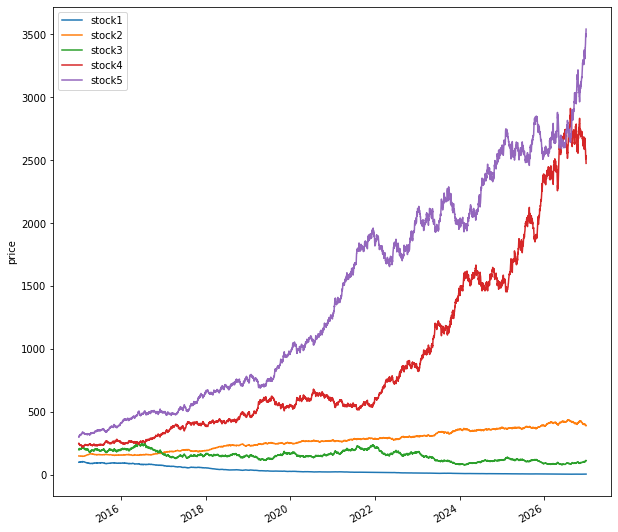

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
prices_open_df.plot(ax=ax)
ax.legend(loc='best')
ax.set_ylabel('price')
plt.show()

In [9]:
rv_df.head()

,stock1,stock2,stock3,stock4,stock5
2015-01-01 09:35:00,0.000044,0.000014,0.000210,0.000114,0.000064
2015-01-02 09:35:00,0.000041,0.000017,0.000161,0.000076,0.000047
2015-01-03 09:35:00,0.000046,0.000019,0.000197,0.000092,0.000058
2015-01-04 09:35:00,0.000041,0.000016,0.000255,0.000140,0.000082
2015-01-05 09:35:00,0.000053,0.000020,0.000164,0.000103,0.000064


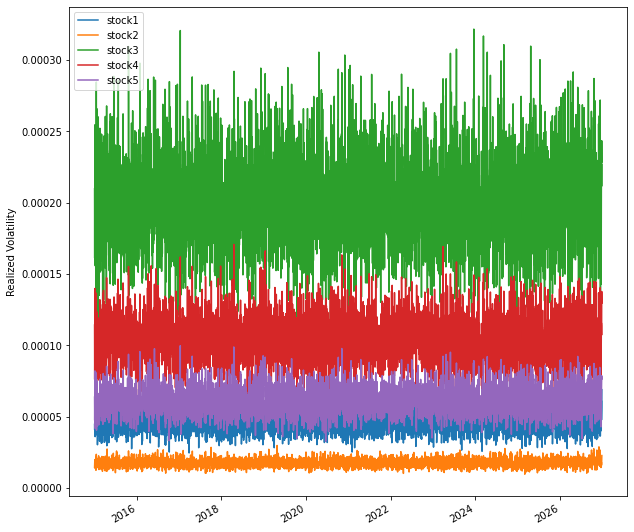

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
rv_df.plot(ax=ax)
ax.legend(loc='best')
ax.set_ylabel('Realized Volatility')
plt.show()

# 3.モデルの定義



```LSTM_RV_PF```モデルは次のような構造を取る．特徴抽出器にはLSTMを使用した．

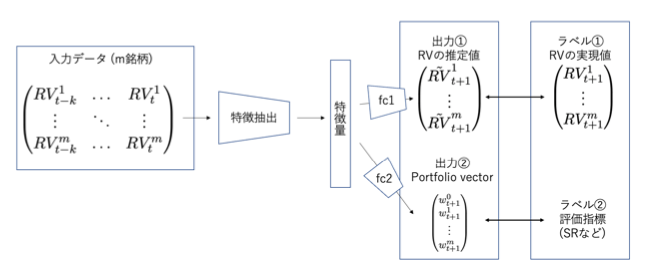

In [ ]:
from IPython.display import Image, display_png
IMG_PATH = ROOT_PATH / 'img'
display_png(Image(str(IMG_PATH / 'multitask_model.png')))

In [ ]:
model = LSTM_RV_PF(5, 124, 5)

# 4.Datasetの定義

```make_pf_dataset```関数で，```prices_open_df```や```rv_df```をPyTorchのDatasetへと加工する．

In [ ]:
TRAIN_YEARS = [2015, 2016, 2017, 2018, 2019]
VALID_YEARS = [2020, 2021, 2022, 2023, 2024]
INPUT_LENGTH = 4
train_dataset, valid_dataset = make_pf_dataset(prices_open_df, rv_df,
                                               TRAIN_YEARS, VALID_YEARS, 
                                               INPUT_LENGTH)

# 4.訓練

```train_rv_pf```によって，モデルの訓練を行う．```model```はポートフォリオベクトル```w```と，一期先のボラティリティの予測値```rv_pred```を出力する．それぞれの出力値をもとにSharp RatioとRealized Volatilityの平均二乗誤差の重み付き和を損失関数として勾配降下法を実施する．```lam1```がSharp Ratioにかかる重みで，```lam2```が平均二乗誤差にかかる重みである．

訓練中にSharp Ratioを計算するための部分期間```loss_interval```を小さく設定すると収益率の分散```train_var_r```が小さくなりすぎてしまい，Sharp Ratioの値がnanになってしまった．


device:cpu
episode1/30 [Sharp Ratio]tra:0.1158 val:0.1318 [RV loss]tra:0.00507789 val:0.00213676
model saving to >> checkpoints/lstm_rv_pf_best.tar
episode2/30 [Sharp Ratio]tra:0.2039 val:0.3681 [RV loss]tra:0.00133233 val:0.00020957
model saving to >> checkpoints/lstm_rv_pf_best.tar
episode3/30 [Sharp Ratio]tra:0.3921 val:0.4071 [RV loss]tra:0.00016124 val:0.00035924
model saving to >> checkpoints/lstm_rv_pf_best.tar
episode4/30 [Sharp Ratio]tra:0.3334 val:0.2883 [RV loss]tra:0.00016480 val:0.00002902
model saving to >> checkpoints/lstm_rv_pf_last.tar
episode5/30 [Sharp Ratio]tra:0.3634 val:0.4169 [RV loss]tra:0.00005932 val:0.00006342
model saving to >> checkpoints/lstm_rv_pf_best.tar
episode6/30 [Sharp Ratio]tra:0.4207 val:0.3810 [RV loss]tra:0.00004357 val:0.00001609
model saving to >> checkpoints/lstm_rv_pf_last.tar
episode7/30 [Sharp Ratio]tra:0.4320 val:0.4415 [RV loss]tra:0.00003878 val:0.00003563
model saving to >> checkpoints/lstm_rv_pf_best.tar
episode8/30 [Sharp Ratio]tra:0

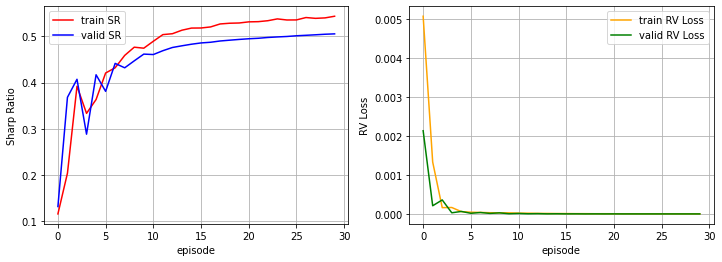

In [ ]:
model = LSTM_RV_PF(5, 124, 5)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
INITIAL_PV = 1
LAM1 = 1
LAM2 = 0.2
LAM3 = 1e-02
LOSS_INTERVAL = 500
BEST_SAVE_PATH = ROOT_PATH / 'checkpoints' / 'lstm_rv_pf_best.tar'
LAST_SAVE_PATH = ROOT_PATH / 'checkpoints' / 'lstm_rv_pf_last.tar'
NUM_EPISODE = 30
COMMISSION_RATE = 0.0
model = train_rv_pf(model, DEVICE, INITIAL_PV,
                    LAM1, LAM2, LAM3, LOSS_INTERVAL,
                    train_dataset, valid_dataset,
                    BEST_SAVE_PATH, LAST_SAVE_PATH, 
                    NUM_EPISODE, COMMISSION_RATE, SEED)

train/valid共に，平均二乗誤差が小さく，Sharp Ratioが大きくなる方向に学習できている．

# 5.テスト

```backtest_multiple_period```により，2025,2026年のデータを利用して訓練済みモデルのテストを行う．1月1日から4日ごとにテストの開始時点を設定し，開始時点から1ヶ月間のバックテストによってSharp RatioおよびRealized Volatilityの推定値の平均二乗誤差を保存する．

In [46]:
test_dates = []
TEST_YEARS = [2025,2026]
for date in prices_open_df.index:
    if date.year in TEST_YEARS:
        test_dates.append(date)
PERIOD_LENGTH = 30
INTERVAL = 4
model = LSTM_RV_PF(5, 124, 5)
checkpoint = torch.load(BEST_SAVE_PATH)
model.load_state_dict(checkpoint['model_state_dict'])

test_df = backtest_multiple_period(model, DEVICE, INITIAL_PV, 
                                   prices_open_df, rv_df,
                                   INPUT_LENGTH, test_dates, COMMISSION_RATE,
                                   PERIOD_LENGTH, INTERVAL, DATA_PATH)

In [47]:
test_df.head()

,start date,end date,Sharp Ratio,RV Loss
0,2025-01-01 09:35:00,2025-01-31 09:35:00,0.493864,8.784374e-09
1,2025-01-05 09:35:00,2025-02-04 09:35:00,0.416409,8.846134e-09
2,2025-01-09 09:35:00,2025-02-08 09:35:00,0.342081,8.889158e-09
3,2025-01-13 09:35:00,2025-02-12 09:35:00,0.206340,8.915976e-09
4,2025-01-17 09:35:00,2025-02-16 09:35:00,-0.012266,8.905290e-09


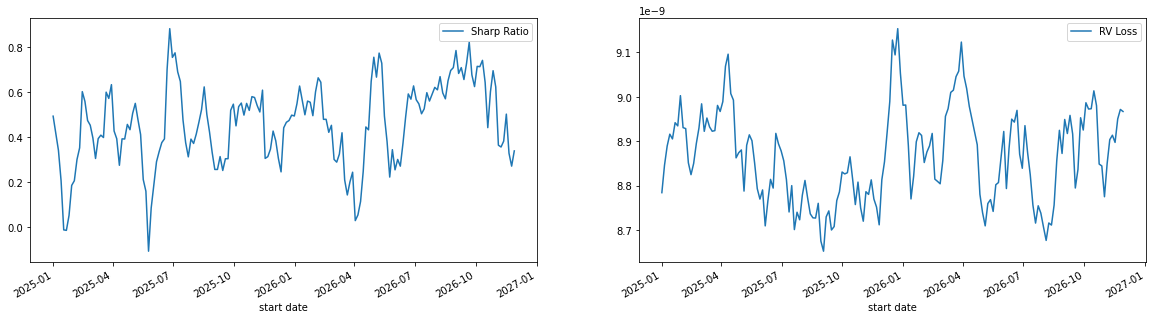

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
test_df.plot(x='start date', y='Sharp Ratio', ax=axes[0], legend=True)
test_df.plot(x='start date', y='RV Loss', ax=axes[1], legend=True)

In [49]:
corr_SR_RV_loss = test_df.corr()
print('Correlation between RV Loss and Sharp Ratio')
corr_SR_RV_loss

Correlation between RV Loss and Sharp Ratio


,Sharp Ratio,RV Loss
Sharp Ratio,1.000000,-0.163421
RV Loss,-0.163421,1.000000


# 6.今後について

- 今回はシミュレーションデータを利用したため，データがボラティリティ・クラスタリングやレバレッジ効果といった，ボラティリティ予測の重要な手がかりになりうる性質を持っていない．次回は実際の株式市場の高頻度データを利用して実験する．
- 他のアルゴリズムも実装して提案手法との比較を行う．
